In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_60 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


from torchsampler import ImbalancedDatasetSampler

2025-06-06 10:48:55.974787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=64, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=32,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_vae"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [6]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.2146
[VAE Pretrain] Epoch 50/300 Avg ELBO: -365.1322 (Recon: -366.3469, KLw: 1.2146)
[Epoch 100] KL weight: 0.0041, KL: 2.7390
[VAE Pretrain] Epoch 100/300 Avg ELBO: -437.5338 (Recon: -440.2728, KLw: 2.7390)
[Epoch 150] KL weight: 0.0062, KL: 4.2841
[VAE Pretrain] Epoch 150/300 Avg ELBO: -466.7821 (Recon: -471.0662, KLw: 4.2841)
[Epoch 200] KL weight: 0.0083, KL: 5.5413
[VAE Pretrain] Epoch 200/300 Avg ELBO: -459.3736 (Recon: -464.9148, KLw: 5.5413)
Early stopping triggered at epoch 207!


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_vae/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [ ]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [ ]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=40)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0137
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0089
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0071
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0063
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0060
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0060
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0061
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0064
[SOM] Early stopping at epoch 86


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience =20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 263825


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([263825, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


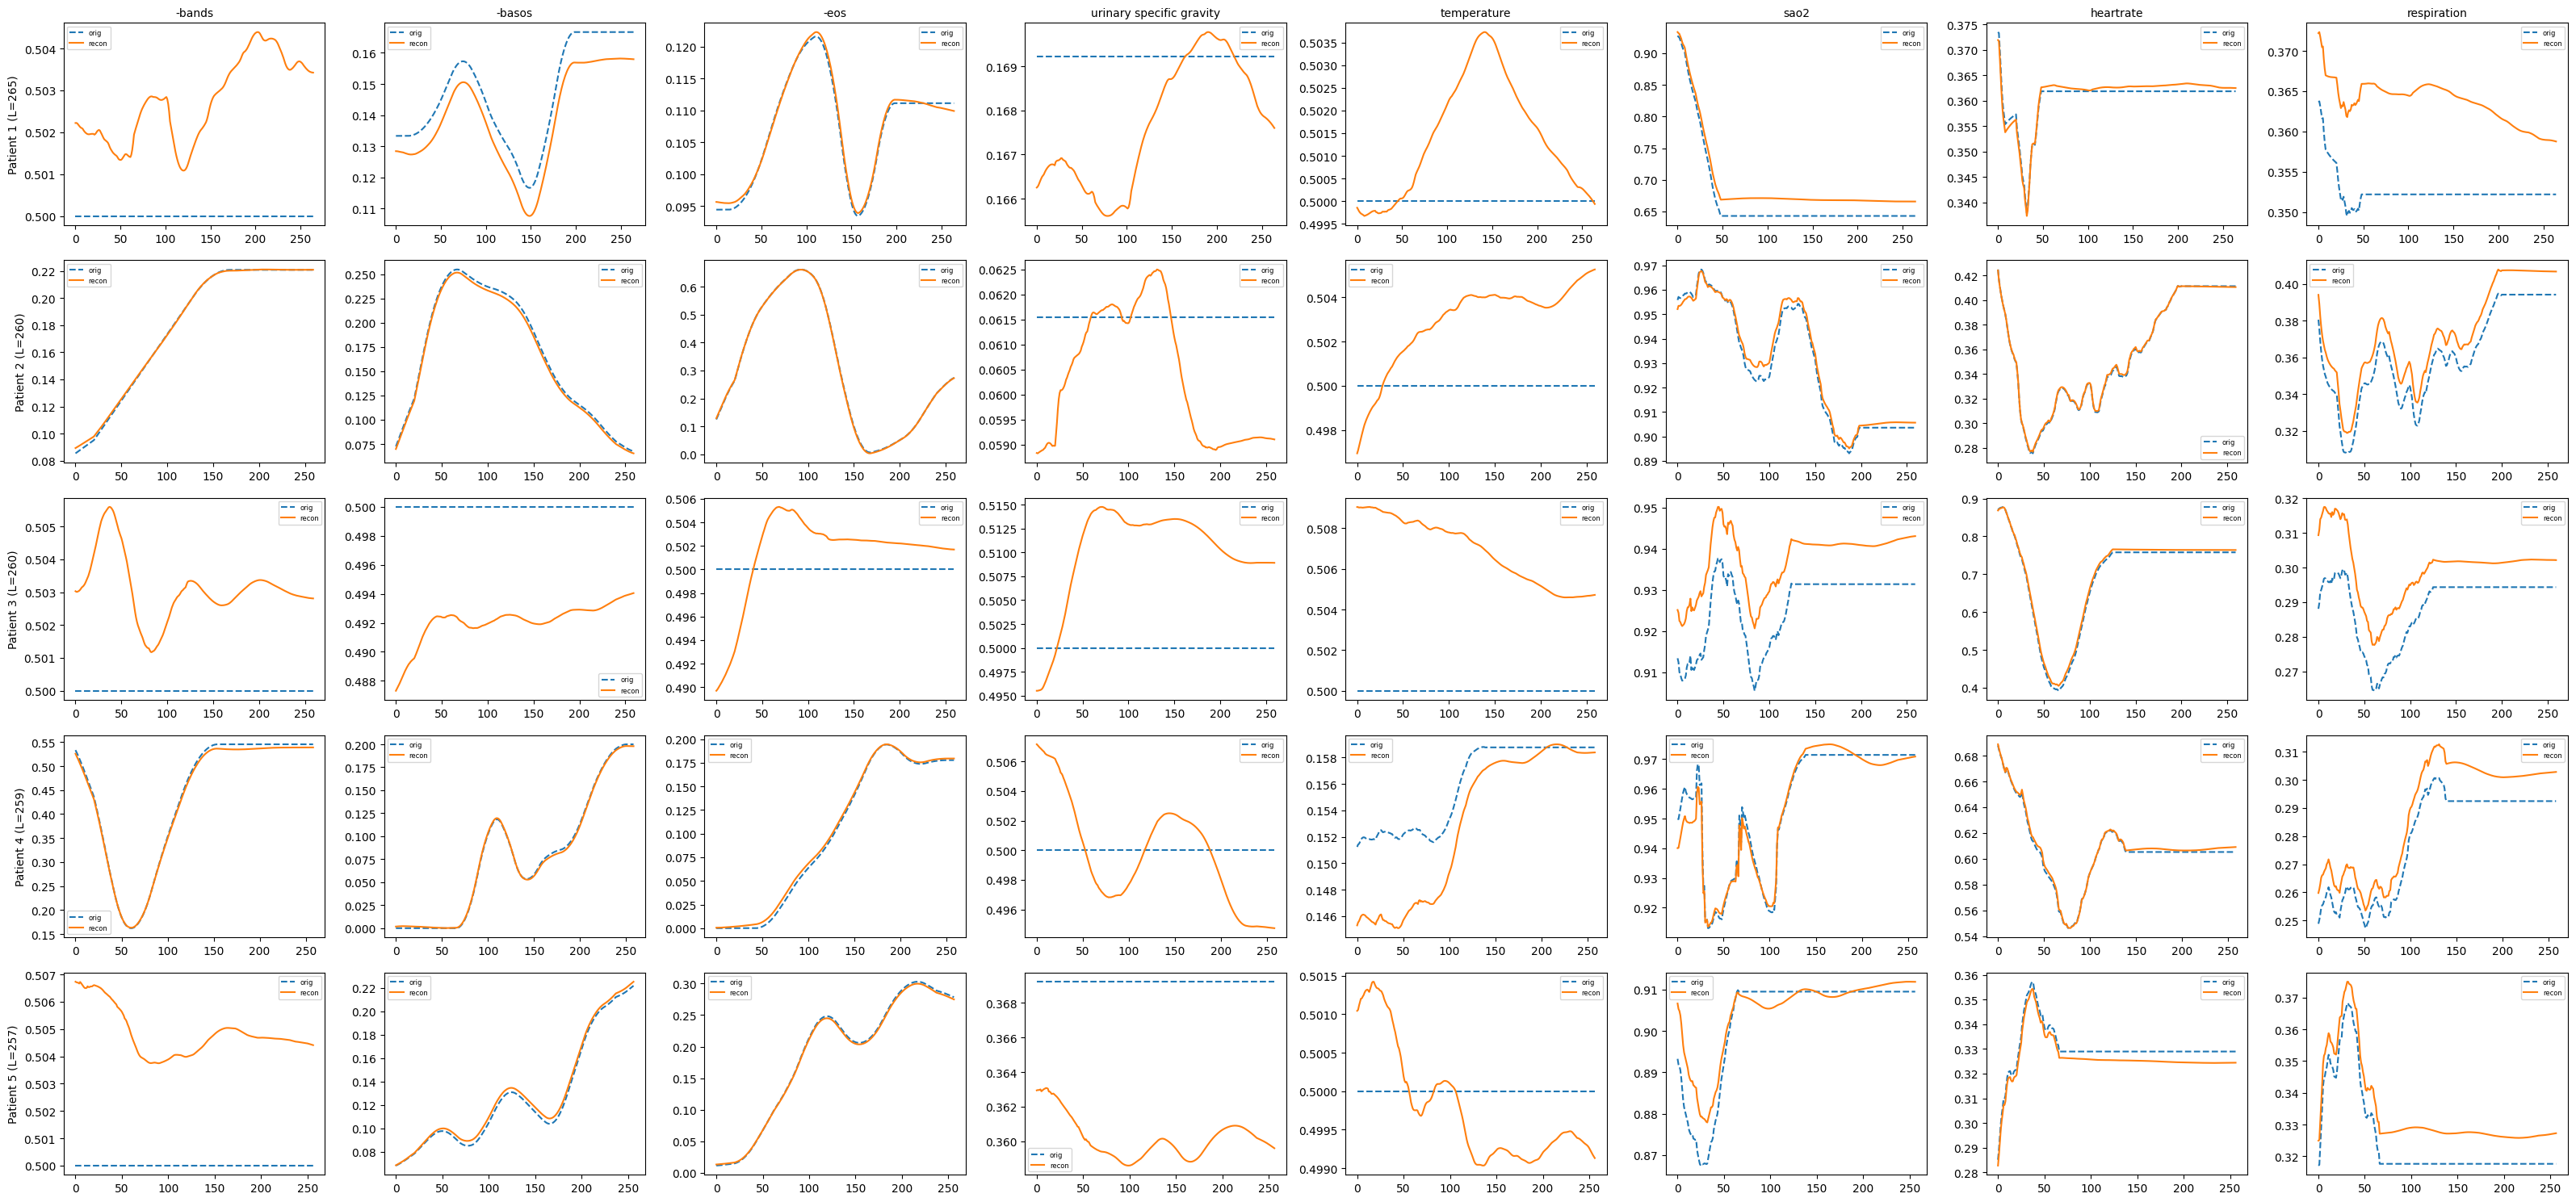

In [8]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 158958 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0266
  Std (overall): 0.3604
  Per-dim mean:
tensor([ 3.6557e-03, -5.6950e-02,  3.4195e-02, -5.7997e-02,  2.3480e-02,
        -1.3822e-02, -7.1464e-01, -2.9357e-02,  1.0670e-02,  2.6539e-02,
         1.0826e-01,  2.9323e-03, -1.9887e-02,  3.9148e-03, -3.1833e-02,
         3.7433e-04,  9.2609e-03, -1.8134e-02, -4.7662e-02,  1.8664e-02,
        -3.6818e-01,  4.8819e-02, -4.5444e-02, -2.8475e-02, -4.3255e-02,
        -9.2453e-04,  4.9437e-02, -1.1414e-02,  4.5843e-02,  5.6581e-02,
        -9.4081e-02, -1.9438e-02, -9.5562e-03, -3.1986e-02,  3.4182e-02,
        -2.4044e-01,  1.8083e-02,  4.9437e-02, -3.2209e-02,  7.2199e-03,
         8.5995e-03, -6.8801e-03,  3.8878e-02,  1.3611e-02,  3.1950e-01,
        -1.3068e-02, -1.9810e-02, -1.9993e-02, -6.0580e-02,  2.4172e-02,
         3.4227e-02,  1.4931e-02, -1.6910e-02,  1.2199e-02,  2.2785e-01,
         1.1197e+00,  9.4755e-01, -6.

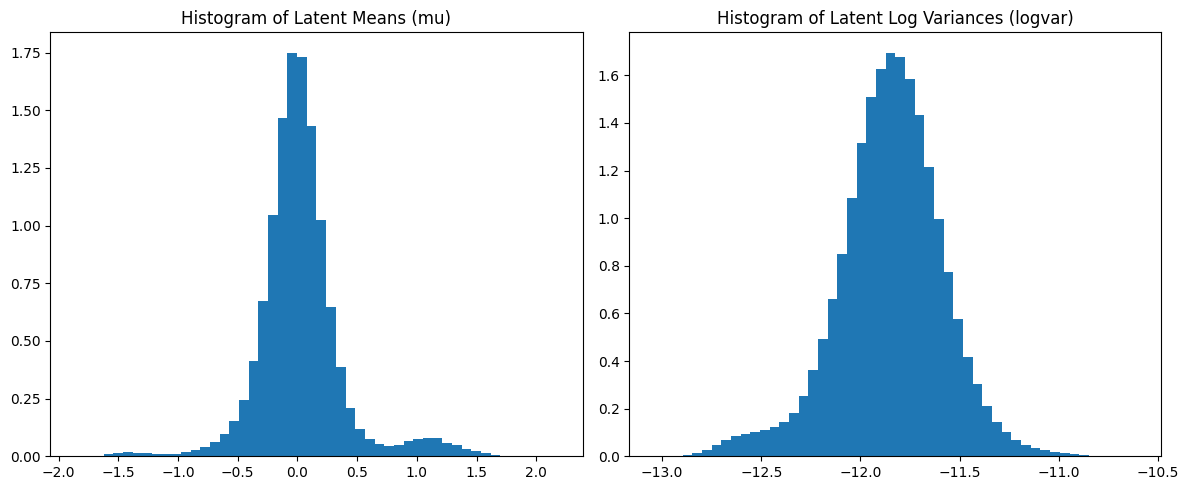

In [9]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

### vae 几乎退化成 ae， logvar ≈ -11.5（对应 σ² ≈ 1e-5）， 无随机性， kl值过大，与先验不服和

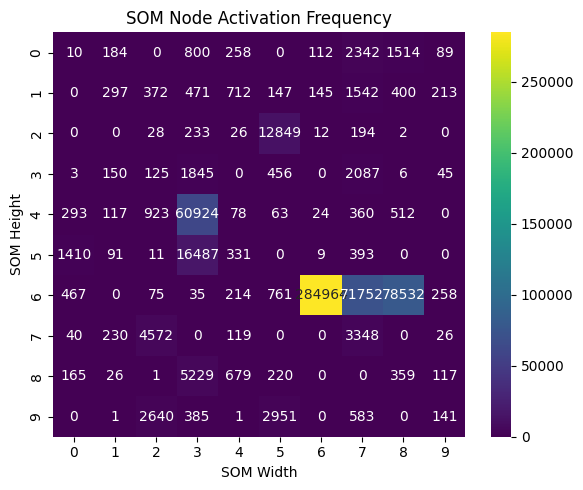

In [16]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

z_all shape: (118348, 128)
y_all shape: (118348,)


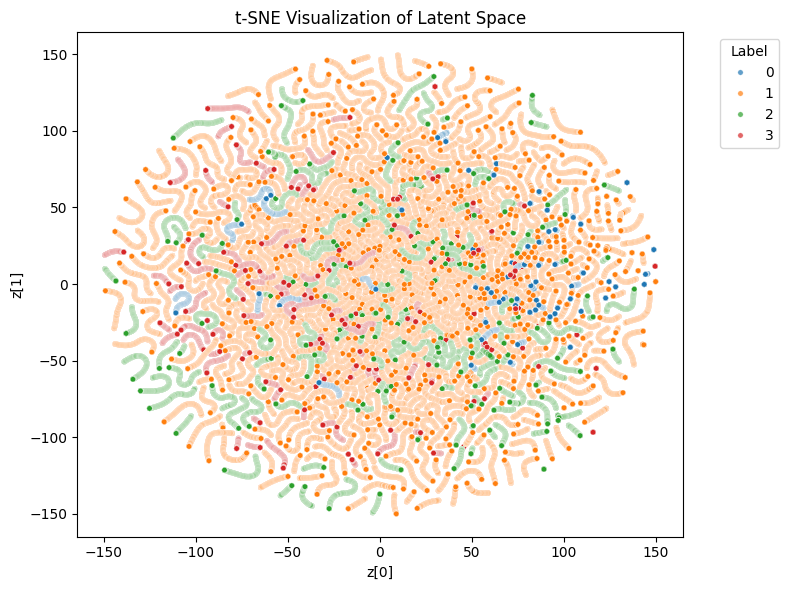

In [13]:
z_all, y_all = collect_latents(model3, data_loader= train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


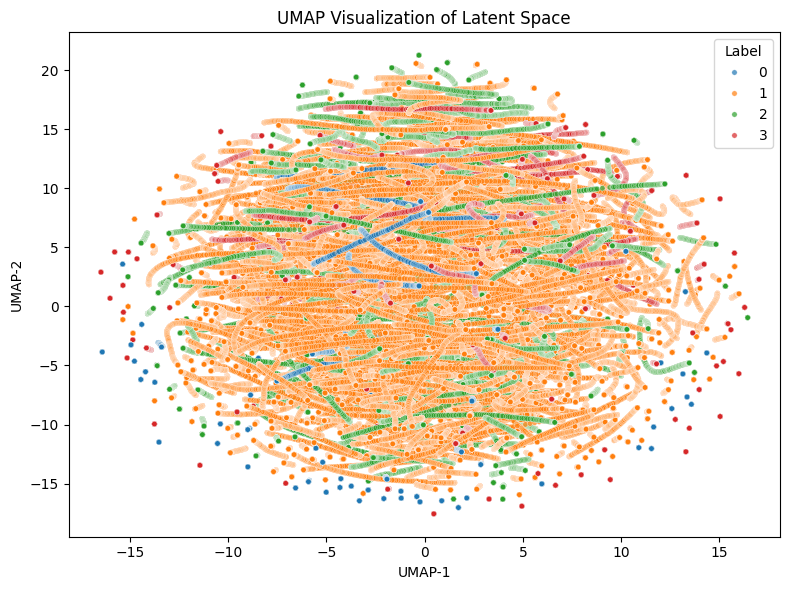

In [14]:
plot_umap(z_all, y_all)

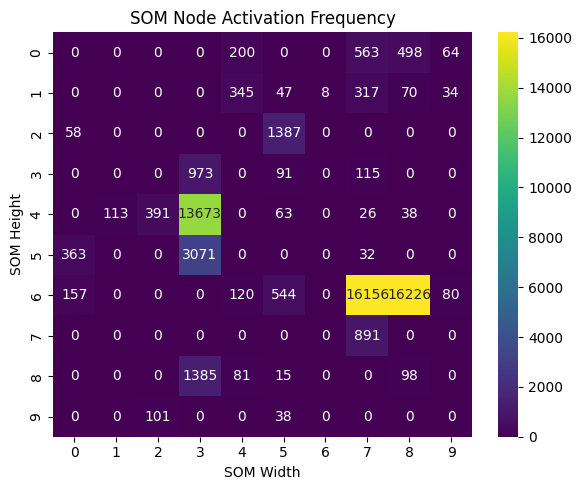

In [20]:
activation_map = compute_som_activation_heatmap(model3,test_loader, device, som_dim=(10, 10))
plot_som_activation_heatmap(activation_map)

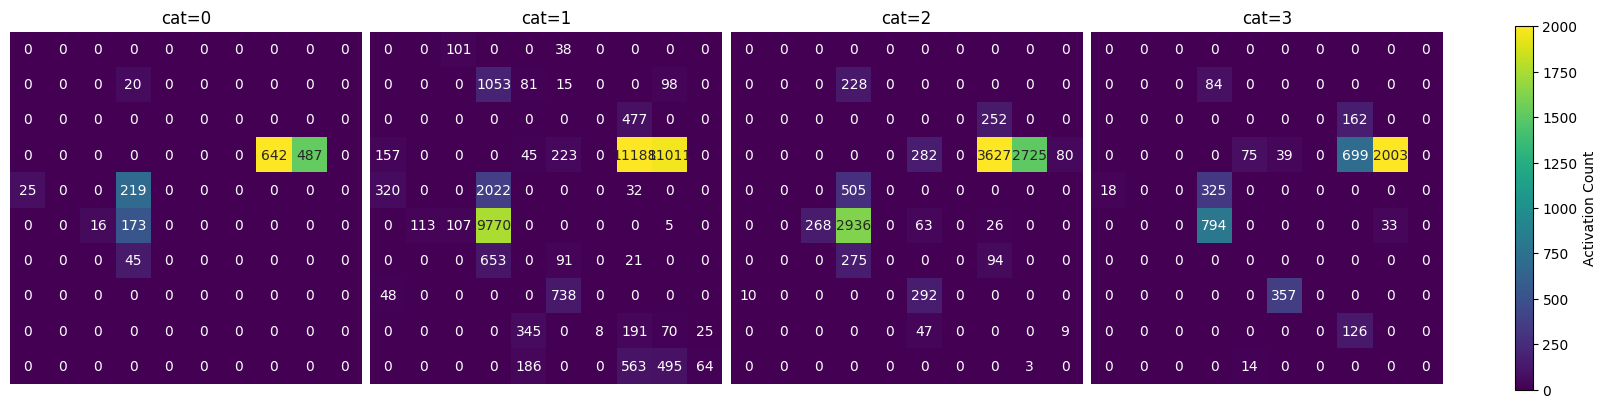

In [22]:
som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

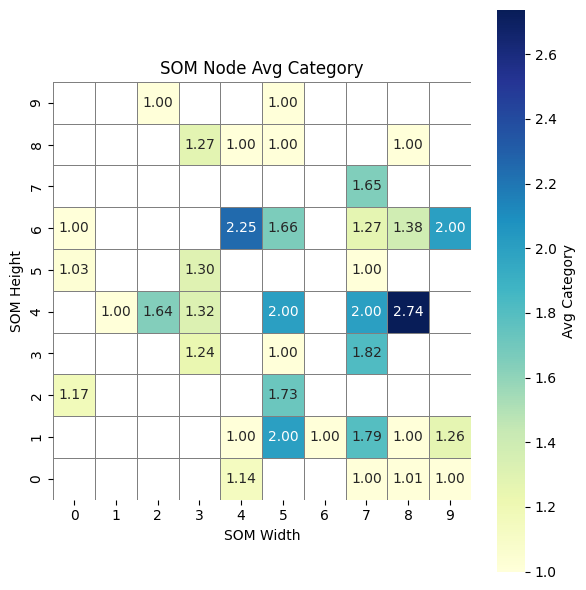

In [24]:
som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)